# US Politics - Twitter analysis

This is some code to look at tweets by and related to prominent US political figures. As a starting point we will be looking at:

- Donald Trump
- Hillary Clinton
- Barack Obama

We're also looking at the responses of media outlets to these tweets, namely:

- BBC World News
- Breitbart
- CBC News
- CBS News
- CNN
- FOX News
- The Guardian
- MSNBC
- NBC News
- Reuters



In [460]:
from IPython.display import Image
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
from keys import WD
from textblob import TextBlob
import re
import matplotlib.ticker as ticker
%matplotlib inline

Let's define some functions to read in the json log files.

In [198]:
def file_date(t):
    date_new = t.strftime("%Y%m%d")
    return date_new

def read_tweets(search_type, name, start, end):
    no_days = (end-start).days
    dtype_dict= {"location":str, "hastags":list, "mentions":list, "t":dt.datetime, \
                 "screen_name":str, "log_time":dt.datetime, "id":int, "content":str, "source":str, \
                 "fav_count":int, "retweet_count":int}

    count = 0
    df_tweets = 0
    for i in range(no_days+1):
        new_date = file_date(start+dt.timedelta(i))
        file_tmp = WD+'/{}-{}-{}.log'.format(search_type, name, new_date)
         
        try:
            df_tmp = pd.read_json(file_tmp, lines=True, orient='records', dtype=dtype_dict)
            if count == 0:
                df_tweets = df_tmp
            else:
                df_tweets = pd.concat([df_tweets,df_tmp])
            count +=1
            
        except:
            #print 'No tweets on:', start+dt.timedelta(i)
            continue
        
    try:
        df_tweets['t'] = pd.to_datetime(df_tweets['t'], format="%Y-%m-%d:%H:%M:%S")
        df_tweets = df_tweets.set_index('t')
        #display(df_tweets.head(2))
        print len(df_tweets), 'tweets collected on', count, 'days for', search_type, name
        return df_tweets
    except:
        print 'No tweets found in time range for', name
        return df_tweets


In [468]:
start_date = dt.date(2018,1,1)
end_date = dt.date.today()

# Politicians
DJT_tweets = read_tweets('tweets', 'realDonaldTrump',start_date, end_date)
HRC_tweets = read_tweets('tweets', 'HillaryClinton',start_date, end_date)
BHO_tweets = read_tweets('tweets', 'BarackObama',start_date, end_date)

# News outlets
BBC_tweets = read_tweets('tweets', 'BBCWorld',start_date, end_date)
Breitbart_tweets = read_tweets('tweets', 'BreitbartNews',start_date, end_date)
CBC_tweets = read_tweets('tweets', 'cbcnews',start_date, end_date)
CBS_tweets = read_tweets('tweets', 'CBSNews',start_date, end_date)
CNN_tweets = read_tweets('tweets', 'cnn',start_date, end_date)
FOX_tweets = read_tweets('tweets', 'foxnews',start_date, end_date)
Guardian_tweets = read_tweets('tweets', 'guardian',start_date, end_date)
MSNBC_tweets = read_tweets('tweets', 'MSNBC',start_date, end_date)
NBC_tweets = read_tweets('tweets', 'NBCNews',start_date, end_date)
Reuters_tweets = read_tweets('tweets', 'Reuters',start_date, end_date)

# List of News tweets
News_tweets = [BBC_tweets, Breitbart_tweets, CBC_tweets, CBS_tweets, CNN_tweets, \
               FOX_tweets, Guardian_tweets, MSNBC_tweets, NBC_tweets, Reuters_tweets]
News_names = ['BBC', 'Breitbart', 'CBC', 'CBS', 'CNN', \
               'FOX', 'Guardian', 'MSNBC', 'NBC', 'Reuters']

207 tweets collected on 32 days for tweets realDonaldTrump
17 tweets collected on 11 days for tweets HillaryClinton
1 tweets collected on 1 days for tweets BarackObama
436 tweets collected on 7 days for tweets BBCWorld
387 tweets collected on 10 days for tweets BreitbartNews
484 tweets collected on 8 days for tweets cbcnews
849 tweets collected on 6 days for tweets CBSNews
814 tweets collected on 5 days for tweets cnn
1206 tweets collected on 5 days for tweets foxnews
1146 tweets collected on 5 days for tweets guardian
467 tweets collected on 9 days for tweets MSNBC
746 tweets collected on 6 days for tweets NBCNews
1352 tweets collected on 5 days for tweets Reuters


We want to filter some plots by keyword. Let's write a function for that.

In [229]:
def filter(df,kw):
    
    df = df[df['content'].str.contains(kw)]

    return df

In [240]:
BBC_Trump = filter(BBC_tweets,'Trump|POTUS')
Breitbart_Trump = filter(Breitbart_tweets,'Trump|POTUS')
CBC_Trump = filter(CBC_tweets,'Trump|POTUS')
CBS_Trump = filter(CBS_tweets,'Trump|POTUS')
CNN_Trump = filter(CNN_tweets,'Trump|POTUS')
FOX_Trump = filter(FOX_tweets,'Trump|POTUS')
Guardian_Trump = filter(Guardian_tweets,'Trump|POTUS')
MSNBC_Trump = filter(MSNBC_tweets,'Trump|POTUS')
NBC_Trump = filter(NBC_tweets,'Trump|POTUS')
Reuters_Trump = filter(Reuters_tweets,'Trump|POTUS')

Let's do some sentiment analysis on this to see if we can detect some bias. We'll use textblob which has a pre-trained sentiment analysis tool. While this may not be the most accurate, we can use it at a starting point. Let's first define some functions to a) remove links etc from tweets and b) find the sentiment of a given tweet.

In [264]:
def clean_tweet(text):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())

def sentiment_analysis(text):

    analysis = TextBlob(clean_tweet(text))
    # Let's go with the direct polarity values
    #return analysis.sentiment.polarity
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1


In [469]:
sentiments_News_Trump = []
num_tweets_Trump = []
count  = 0
for i in range(len(News_tweets)):
    filtered = filter(News_tweets[i], 'Trump|POTUS')
    if count == 0:
        news_trump = filtered
    else:
        news_trump = pd.concat([news_trump,filtered])
    num_tweets_Trump.append(len(filtered))
    print len(filtered), 'tweets about Trump collected by', News_names[i]
    sentiments = np.array([ sentiment_analysis(tweet) for tweet in filtered['content'] ])
    avg_sentiment = np.mean(sentiments)
    sentiments_News_Trump.append(avg_sentiment)
    print 'Average sentiment for', News_names[i], 'is', avg_sentiment
    count+=1

sentiments_News_Trump = np.array(sentiments_News_Trump)
sorti = np.argsort(sentiments_News_Trump)
print 'The sentiments from lowest to highest are:', np.array(News_names)[sorti] 

44 tweets about Trump collected by BBC
Average sentiment for BBC is 0.25
33 tweets about Trump collected by Breitbart
Average sentiment for Breitbart is -0.09090909090909091
19 tweets about Trump collected by CBC
Average sentiment for CBC is 0.47368421052631576
226 tweets about Trump collected by CBS
Average sentiment for CBS is 0.4557522123893805
225 tweets about Trump collected by CNN
Average sentiment for CNN is 0.26222222222222225
443 tweets about Trump collected by FOX
Average sentiment for FOX is 0.2528216704288939
75 tweets about Trump collected by Guardian
Average sentiment for Guardian is 0.32
198 tweets about Trump collected by MSNBC
Average sentiment for MSNBC is 0.3333333333333333
157 tweets about Trump collected by NBC
Average sentiment for NBC is 0.4840764331210191
194 tweets about Trump collected by Reuters
Average sentiment for Reuters is 0.29896907216494845
The sentiments from lowest to highest are: ['Breitbart' 'BBC' 'FOX' 'CNN' 'Reuters' 'Guardian' 'MSNBC' 'CBS' 'CBC

Let's plot this as a bar chart.

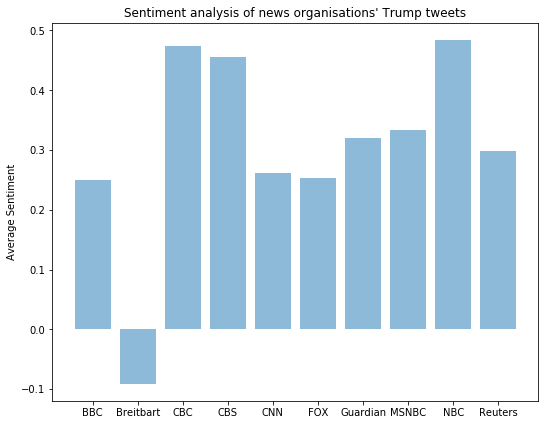

In [470]:
fig1 = plt.figure(figsize=(9,7))
ax1  = fig1.add_axes([0.15,0.15,0.75,0.75])

xpos = range(len(News_names))
ax1.bar(xpos, sentiments_News_Trump, align='center', alpha=0.5)
ax1.set_xticks(xpos)
ax1.set_xticklabels(News_names)
ax1.set_ylabel('Average Sentiment')
ax1.set_title("Sentiment analysis of news organisations' Trump tweets")
 
fig1.savefig('Trump_News_sentiment.pdf')
plt.show()

We can do the same thing for Hillary Clinton and Barack Obama.

In [471]:
sentiments_News_Obama = []
num_tweets_Obama = []
for i in range(len(News_tweets)):
    filtered = filter(News_tweets[i], 'Obama')
    num_tweets_Obama.append(len(filtered))
    print len(filtered), 'tweets about Obama collected by', News_names[i]
    sentiments = np.array([ sentiment_analysis(tweet) for tweet in filtered['content'] ])
    avg_sentiment = np.mean(sentiments)
    sentiments_News_Obama.append(avg_sentiment)
    print 'Average sentiment for', News_names[i], 'is', avg_sentiment

sentiments_News_Obama = np.array(sentiments_News_Obama)
sorti = np.argsort(sentiments_News_Obama)
print 'The sentiments from lowest to highest are:', np.array(News_names)[sorti] 


sentiments_News_Clinton = []
num_tweets_Clinton = []
for i in range(len(News_tweets)):
    filtered = filter(News_tweets[i], 'Hillary|Clinton')
    num_tweets_Clinton.append(len(filtered))
    print len(filtered), 'tweets about Clinton collected by', News_names[i]
    sentiments = np.array([ sentiment_analysis(tweet) for tweet in filtered['content'] ])
    avg_sentiment = np.mean(sentiments)
    sentiments_News_Clinton.append(avg_sentiment)
    print 'Average sentiment for', News_names[i], 'is', avg_sentiment

sentiments_News_Clinton = np.array(sentiments_News_Clinton)
sorti = np.argsort(sentiments_News_Trump)
print 'The sentiments from lowest to highest are:', np.array(News_names)[sorti] 


0 tweets about Obama collected by BBC
Average sentiment for BBC is nan
4 tweets about Obama collected by Breitbart
Average sentiment for Breitbart is 0.0
0 tweets about Obama collected by CBC
Average sentiment for CBC is nan
10 tweets about Obama collected by CBS
Average sentiment for CBS is 0.5
12 tweets about Obama collected by CNN
Average sentiment for CNN is -0.16666666666666666
23 tweets about Obama collected by FOX
Average sentiment for FOX is 0.0
0 tweets about Obama collected by Guardian
Average sentiment for Guardian is nan
0 tweets about Obama collected by MSNBC
Average sentiment for MSNBC is nan
6 tweets about Obama collected by NBC
Average sentiment for NBC is -0.3333333333333333
0 tweets about Obama collected by Reuters
Average sentiment for Reuters is nan
The sentiments from lowest to highest are: ['NBC' 'CNN' 'Breitbart' 'FOX' 'CBS' 'BBC' 'CBC' 'Guardian' 'MSNBC'
 'Reuters']
2 tweets about Clinton collected by BBC
Average sentiment for BBC is 0.0
0 tweets about Clinton c

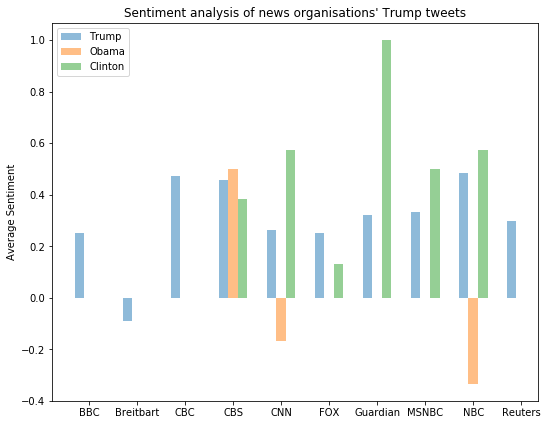

In [472]:
# plot this


fig2 = plt.figure(figsize=(9,7))
ax2  = fig2.add_axes([0.15,0.15,0.75,0.75])
width=0.2

xpos = np.arange(len(News_names))
ax2.bar(xpos-width, sentiments_News_Trump, width,  alpha=0.5, label='Trump')
ax2.bar(xpos, sentiments_News_Obama, width, alpha=0.5, label='Obama')
ax2.bar(xpos+width, sentiments_News_Clinton, width,alpha=0.5, label='Clinton')
ax2.set_xticks(xpos)
ax2.set_xticklabels(News_names)
ax2.set_ylabel('Average Sentiment')
ax2.set_title("Sentiment analysis of news organisations' Trump tweets")
ax2.legend(loc='upper left')
 
fig2.savefig('Trump_Obama_Clinton_News_sentiment.pdf')
plt.show()

We can see from the above that this is lacking data currently. We don't have enough tweets available to perform meaningful analysis yet. While we at least have hudreds of tweets about Trump, we only have negligible numbers for both Hillary Clinton and Barack Obama. 

Now let's look at the timeline of tweets.

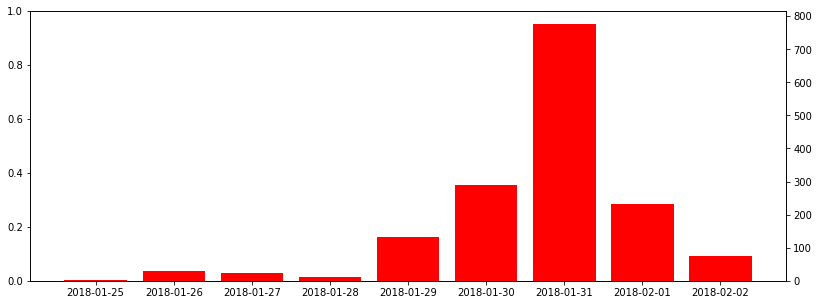

In [326]:
days_dt = DJT_tweets.resample('1D').count()['content'].index
counts_dt = DJT_tweets.resample('1D').count()['content'].values
days_dt = days_dt.map(lambda t: t.strftime('%Y-%m-%d'))

days_news_dt = news_trump.resample('1D').count()['content'].index
counts_news_dt = news_trump.resample('1D').count()['content'].values
days_news_dt = days_news_dt.map(lambda t: t.strftime('%Y-%m-%d'))

fig3 = plt.figure(figsize=(14,5))
ax3  = fig3.add_axes([0.15,0.15,0.75,0.75])
ax3b = ax3.twinx()

#ax3.bar(days_dt,counts_dt, color='b')
ax3b.bar(days_news_dt,counts_news_dt, color='r')

fig3.autofmt_xdate()
#fig2.savefig('Trump_Obama_Clinton_News_sentiment.pdf')

Let's find times when Donald Trump tweets about Barack Obama and Hillary Clinton.

In [438]:
DJT_BO = filter(DJT_tweets, 'Obama')
DJT_BO_times = DJT_BO.index
DJT_HC = filter(DJT_tweets, 'Hillary')
DJT_HC_times = DJT_HC.index

Now let's look at a subset of the average users' tweets.

In [331]:
search_BO = read_tweets('search', 'Obama',start_date, end_date)
search_BO2 = read_tweets('search', 'BarackObama',start_date, end_date)
search_BO = pd.concat([search_BO,search_BO2])


22478 tweets collected on 4 days for search Obama
35849 tweets collected on 4 days for search BarackObama


Let's quickly do some sentiment analysis on these tweets.

In [333]:
sentiments_BO = np.array([ sentiment_analysis(tweet) for tweet in search_BO['content'] ])
avg_sentiment_BO = np.mean(sentiments_BO)
print 'The average sentiment for Obama is:', avg_sentiment_BO

The average sentiment for Obama is: 0.13220292488898794


Let's also do the same for Hillary Clinton and Donald Trump.

In [481]:
search_HC = read_tweets('search', 'Hillary',start_date, end_date)
search_HC2 = read_tweets('search', 'HillaryClinton',start_date, end_date)
search_HC = pd.concat([search_HC,search_HC2])

search_DJT = read_tweets('search', 'Trump',start_date, end_date)
search_DJT2 = read_tweets('search', 'realDonaldTrump',start_date, end_date)
search_DJT = pd.concat([search_DJT,search_DJT2])

sentiments_HC = np.array([ sentiment_analysis(tweet) for tweet in search_HC['content'] ])
avg_sentiment_HC = np.mean(sentiments_HC)
print 'The average sentiment for Hillary Clinton is:', avg_sentiment_HC

sentiments_DJT = np.array([ sentiment_analysis(tweet) for tweet in search_DJT['content'] ])
avg_sentiment_DJT = np.mean(sentiments_DJT)
print 'The average sentiment for Trump is:', avg_sentiment_DJT


20370 tweets collected on 4 days for search Hillary
39019 tweets collected on 4 days for search HillaryClinton
19754 tweets collected on 4 days for search Trump
40328 tweets collected on 4 days for search realDonaldTrump
The average sentiment for Hillary Clinton is: 0.11135058680900503
[ 0  1  0 ...  1 -1  0]
The average sentiment for Trump is: 0.1121966645584368


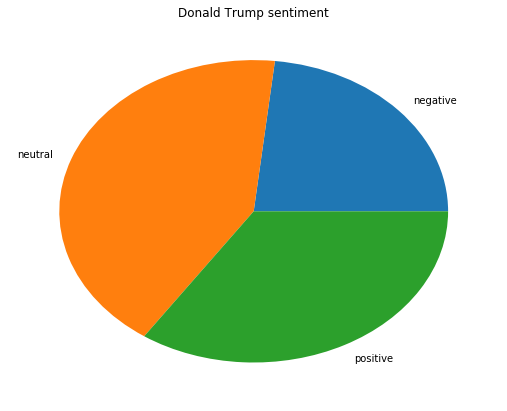

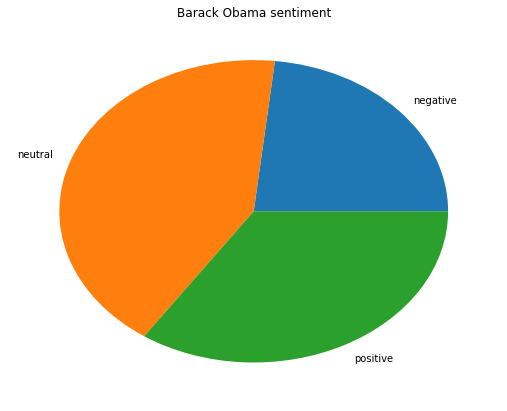

In [467]:
unique, counts = np.unique(sentiments_DJT, return_counts=True)
sent_DJT_counts = dict(zip(unique, counts))

sent_DJC_list = [sent_DJT_counts[-1], sent_DJT_counts[0],sent_DJT_counts[1]]
sent_DJC_list = 100*np.array(sent_DJC_list/sum(sent_DJC_list))

fig4 = plt.figure(figsize=(9,7))
ax4  = fig4.add_axes([0.15,0.15,0.75,0.75])
ax4.pie(sent_DJC_list, labels=['negative', 'neutral', 'positive'])
ax4.set_title('Donald Trump sentiment')
plt.show()

unique, counts = np.unique(sentiments_BO, return_counts=True)
sent_BO_counts = dict(zip(unique, counts))

sent_BO_list = [sent_BO_counts[-1], sent_BO_counts[0],sent_BO_counts[1]]
sent_BO_list = 100*np.array(sent_BO_list/sum(sent_BO_list))

fig4a = plt.figure(figsize=(9,7))
ax4a  = fig4a.add_axes([0.15,0.15,0.75,0.75])
ax4a.pie(sent_DJC_list, labels=['negative', 'neutral', 'positive'])
ax4a.set_title('Barack Obama sentiment')
plt.show()

In [422]:
#times_search_BO = search_BO.resample('2H').count()['content'].index
#counts_search_BO = search_BO.resample('2H').count()['content'].values
#times_search_BO = times_search_BO.map(lambda t: t.strftime('%Y-%m-%d:%H:%M:%S'))#

#DJT_BO_times_2h = DJT_BO.resample('2H').count()['content'].index
#DJT_BO_counts_2h = DJT_BO.resample('2H').count()['content'].values

#fig4 = plt.figure(figsize=(9,7))
#ax4  = fig4.add_axes([0.15,0.15,0.75,0.75])

#ax4.plot(times_search_BO, counts_search_BO)
#ax4.xaxis.set_major_locator(ticker.MultipleLocator(5))
#xlabels = ax4.get_xticklabels() 
#for label in xlabels: 
#    label.set_rotation(45) 
    
# Add Trumps tweets
#ax4b = ax4.twinx()
#ax4b.plot(DJT_BO_times_2h, DJT_BO_counts_2h)
 
#fig2.savefig('Trump_Obama_Clinton_News_sentiment.pdf')
#plt.show()

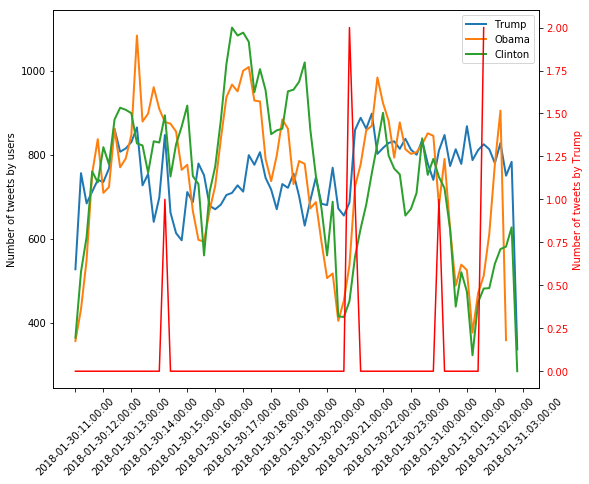

In [483]:
# combined data
times_search_DJT = search_DJT.resample('1H').count()['content'].index
counts_search_DJT = search_DJT.resample('1H').count()['content'].values

times_search_BO = search_BO.resample('1H').count()['content'].index
counts_search_BO = search_BO.resample('1H').count()['content'].values

times_search_HC = search_HC.resample('1H').count()['content'].index
counts_search_HC = search_HC.resample('1H').count()['content'].values



comb = pd.DataFrame(counts_search_DJT, index=times_search_DJT).reset_index()
DJT_tweets_1H = DJT_tweets.resample('1H').count()['content'].to_frame().reset_index()
search_BO_1H = search_BO.resample('1H').count()['content'].to_frame().reset_index()
search_HC_1H = search_HC.resample('1H').count()['content'].to_frame().reset_index()
comb = comb.merge(DJT_tweets_1H, on=['t'], how='left')
comb = comb.merge(search_BO_1H, on=['t'], how='left')
comb = comb.merge(search_HC_1H, on=['t'], how='left')
comb = comb.rename(columns={comb.columns[1]:'tweetsAboutTrump', comb.columns[2]:'tweetsByTrump', \
                            comb.columns[3]:'tweetsAboutObama', comb.columns[4]:'tweetsAboutClinton'})
comb['t'] = comb['t'].map(lambda t: t.strftime('%Y-%m-%d:%H:%M:%S'))


fig5 = plt.figure(figsize=(9,7))
ax5  = fig5.add_axes([0.15,0.15,0.75,0.75])

ax5.plot(comb.t.values, comb.tweetsAboutTrump.values, label='Trump', lw=2.0)
ax5.plot(comb.t.values, comb.tweetsAboutObama.values, label='Obama', lw=2.0)
ax5.plot(comb.t.values, comb.tweetsAboutClinton.values, label='Clinton', lw=2.0)
ax5.xaxis.set_major_locator(ticker.MultipleLocator(5))
xlabels = ax5.get_xticklabels() 
for label in xlabels: 
    label.set_rotation(45) 
    
# Add Trumps tweets
ax5b = ax5.twinx()
ax5b.plot(comb.t.values, comb.tweetsByTrump.values, c='r', label = 'Tweets by Trump')
ax5b.xaxis.set_major_locator(ticker.MultipleLocator(5))
xlabels = ax5b.get_xticklabels() 
for label in xlabels: 
    label.set_rotation(45) 
    
for tl in ax5b.get_yticklabels():
    tl.set_color('r')
ax5.legend()
ax5.set_ylabel('Number of tweets by users')
ax5b.set_ylabel('Number of tweets by Trump', color='r')
 
fig5.savefig('User_Tweets.pdf',bbox_inches='tight')
plt.show()


Let's do the same but only looking at direct replies to the President's account, @realDonaldTrump.

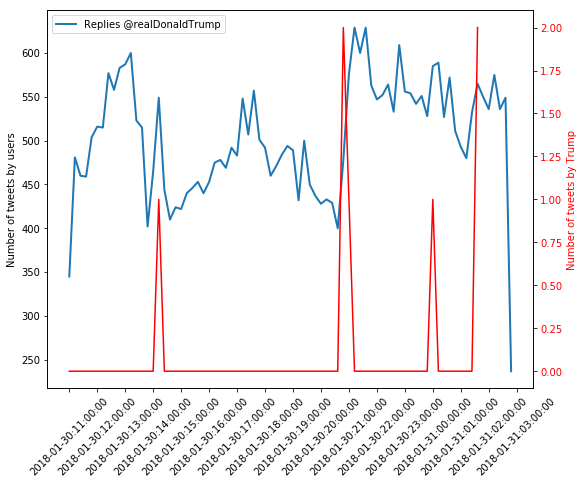

In [484]:
times_search_DJT2 = search_DJT2.resample('1H').count()['content'].index
counts_search_DJT2 = search_DJT2.resample('1H').count()['content'].values


comb = pd.DataFrame(counts_search_DJT2, index=times_search_DJT2).reset_index()
DJT_tweets_1H = DJT_tweets.resample('1H').count()['content'].to_frame().reset_index()
search_BO_1H = search_BO.resample('1H').count()['content'].to_frame().reset_index()
search_HC_1H = search_HC.resample('1H').count()['content'].to_frame().reset_index()
comb = comb.merge(DJT_tweets_1H, on=['t'], how='left')
comb = comb.rename(columns={comb.columns[1]:'repliesTrump', comb.columns[2]:'tweetsByTrump'})
comb['t'] = comb['t'].map(lambda t: t.strftime('%Y-%m-%d:%H:%M:%S'))


fig6 = plt.figure(figsize=(9,7))
ax6  = fig6.add_axes([0.15,0.15,0.75,0.75])

ax6.plot(comb.t.values, comb.repliesTrump.values, label='Replies @realDonaldTrump', lw=2.0)
ax6.xaxis.set_major_locator(ticker.MultipleLocator(5))
xlabels = ax6.get_xticklabels() 
for label in xlabels: 
    label.set_rotation(45) 
    
# Add Trumps tweets
ax6b = ax6.twinx()
ax6b.plot(comb.t.values, comb.tweetsByTrump.values, c='r', label = 'Tweets by Trump')
ax6b.xaxis.set_major_locator(ticker.MultipleLocator(5))
xlabels = ax6b.get_xticklabels() 
for label in xlabels: 
    label.set_rotation(45) 
    
for tl in ax6b.get_yticklabels():
    tl.set_color('r')
ax6.legend()
ax6.set_ylabel('Number of tweets by users')
ax6b.set_ylabel('Number of tweets by Trump', color='r')
 
fig6.savefig('User_Replies_Trump.pdf',bbox_inches='tight')
plt.show()